**Notebook illustrating first iteration of bias correction integrated with default set of evaluation metrics**

This workflow can be used to test the assumptions underlying different bias correction methods and evaluate their performance along a set of metrics (currently still a standard set of default metrics, user will be able to choose in the final package).

Results currently demonstrated for the variable temperature and the bias correction method quantile mapping.

In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import iris
from scipy.stats import norm, laplace

from PACKAGE_NAME.debias import QuantileDeltaMapping, ISIMIP, QuantileMapping
from PACKAGE_NAME.evaluate import evaluation_functions
from PACKAGE_NAME.evaluate import marginal
from PACKAGE_NAME.evaluate import EOT
from PACKAGE_NAME.evaluate import trend_analysis
from PACKAGE_NAME.variables import Temperature, Precipitation

Comment: all evaluation functions used here are still grouped in one module (evaluation_functions) at the moment - functions will be grouped into different modules according to the 'set of metrics' they belong to in the next iteration

**Set variables to investigate**

In [3]:
variables = ['tas']

# 1. Data import and pre-processing

In [4]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    obs = obs_all[:, :, 0:9000]
    obs_validate = obs_all[:, :, 9001:]
    cm_hist = cm[:, :, 0:9000]
    cm_future = cm[:, :, 9001:]

    dates = {
        "time_obs_hist": get_dates(obs),
        #"obs_validate": get_dates(obs_validate),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_future, dates


In [5]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_future, tas_dates = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_future, pr_dates = preprocess_isimip_evaluation_testing_data('pr')

# 2. Evaluation part one - test assumptions

## 2. 1. Goodness of fit

For all parametric methods, distributions are fitted to the CDFs. Default distributions are specified in the individual debiasers. In this evaluation step, the default distributions of the specified debiasers are fitted to the data so that the user can decide whether or not to go ahead with this particular distribution or method, or whether to modify it.

In the example below, the goodness of fit of the default distribution fitted to temperature data is assessed. 
- By calculating the Akaike Information Criterion and plotting the fit and distribution for the location with the worst fit for visual inspection. If a user modifies the distribution she can compare whether this improves the fit according to the AIC
- By evaluating the quantile residuals (timeseries, their autocorrelation and a qq-plot of their transformation to normal) - in this example we see that there is a strong seasonal effect present that the normal distribution does not capture.

**Assessment of AIC**

In [6]:
tas_obs_aic_default = evaluation_functions.goodness_of_fit_aic(variable = 'tas', dataset = tas_obs, distribution_name = 'default')
print(tas_obs_aic_default)

# the user can test different possible distributions on the data and compare the distribution of AIC

     x    y           AIC
0  0.0  0.0  61383.868889
1  0.0  1.0  62163.891585
2  1.0  0.0  61794.248253
3  1.0  1.0  62514.260948


**Visual inspection of worst fit**

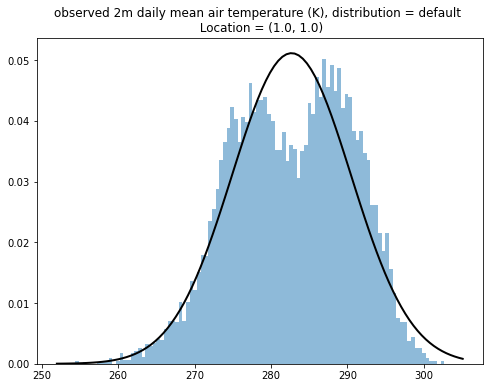

In [7]:
tas_obs_worst_fit = evaluation_functions.goodness_of_fit_plot_worst_fit(variable = 'tas', dataset = tas_obs, 
                                      aic = tas_obs_aic_default, 
                                      data_type = 'observed')

**Inspection of quantile residuals**

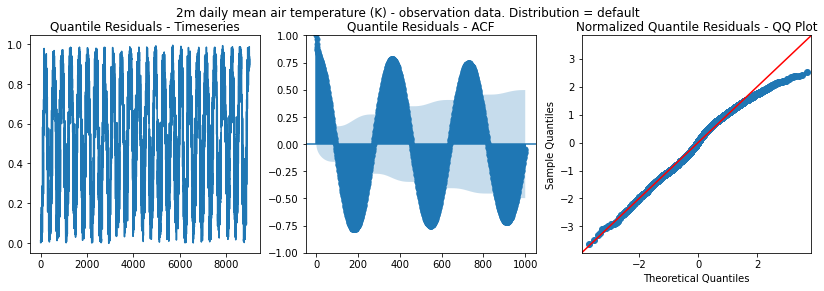

In [8]:
tas_obs_plot_gof = evaluation_functions.goodness_of_fit_plot_quantiles(dataset = tas_obs[:,0,0], 
                                                        variable = 'tas', data_type = 'observation data')

## 2. 2. Stationarity

Work not completed here - There is something weird going on with the Dickie Fuller test we implemented here - we are still trying out different metrics and their implications 

In [9]:
from statsmodels.tsa.stattools import adfuller

def stationarity_adf(dataset):

    adf = np.array([])

    for i in range(dataset.shape[1]):
        for j in range(dataset.shape[2]):
            adf = np.append(adf, adfuller(tas_obs[:, i,j])[1])
            
    return(max(adf))

test = stationarity_adf(tas_cm_hist)
test

1.7001131080632032e-07

# 3. Initialise and apply de-biasers

In [6]:
# Quantile Mapping
QM_tas_debiaser = QuantileMapping.from_variable(variable=Temperature, delta_type="additive")
tas_debiased_QM = QM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future)
test_debiased_hist = QM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_hist)

----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 489.82it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 339.24it/s]


In [9]:
# ISIMIP
ISIMIP_tas_debiaser = ISIMIP.from_variable(variable = 'tas')
tas_debiased_ISIMIP = ISIMIP_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type

# 4. Evaluation of bias corrected results on validation period

After applying the bias correction methods chosen by the user, this section provides a default set of evaluation to assess both the performance of the bias corrected climate model, as well as to get an insight into potential larger biases of the underlying climate model that cannot be corrected through bias correction methods.

In order to assess the performance of a bias correction methods, we need underlying observations to compare the climate simulation to - this is not given in a future period that we actually want to apply bias correction to. We therefore split the historical period into a 'training' and a 'validation' period, and assess the performance of the BC on the validation period where results can still be compared to observations.

## 4. 1. Marginal Aspects

Bias correction methods implemented in this package so far apply marginal corrections (i.e. they are applied location-wise) - as opposed to correcting spatial or temporal correlation etc. This sub-section evaluates the performance of the bias correction method in correcting these marginal aspects through three plots:

**Visual inspection of variable distribution over entire area**

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_84245/295453542.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_hist.show()


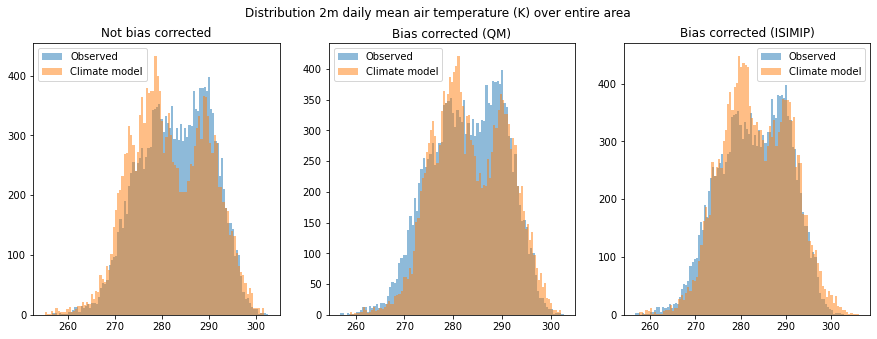

In [13]:
tas_hist = marginal.plot_histogram(variable = 'tas', data_obs = np.ndarray.flatten(tas_obs_validate), 
               data_raw = np.ndarray.flatten(tas_cm_future), bin_number=100, 
               QM=np.ndarray.flatten(tas_debiased_QM), ISIMIP = np.ndarray.flatten(tas_debiased_ISIMIP))
tas_hist.show()

**Percentage bias of mean, 10% and 90% quantile**

Violinplot shows the percentage deviation of the mean, 10% and 90% quantile between observations and raw, and observations and bias corrected climate model over the validation period - calculated at each location, distribution shown over entire region.

In this example, wee see that quantile mapping 'overcorrected' downward a bias in the mean, 10% and 90% quantile.

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_84245/4091285166.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_bias_violinplot.show()


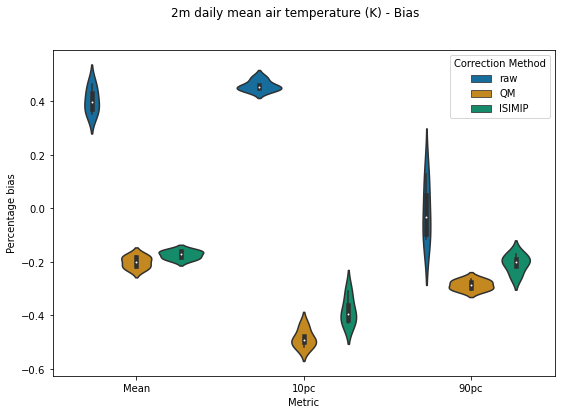

In [14]:
# overview boxplot
tas_bias_violinplot = marginal.plot_bias_distribution(variable = 'tas', data_obs = tas_obs_validate, data_raw = tas_cm_future,
                             QM = tas_debiased_QM, ISIMIP = tas_debiased_ISIMIP)
tas_bias_violinplot.show()

**Spatial distribution of bias**

The shape of the distribution in the violinplot above already gives an indication of whether the bias is especially large over certain areas. The following plot explicitely shows the spacial distribution of biases. Particularly high biases in a certain region could point to deficiencies in the underlying climate model (for example, there could be a mountain range over which the climate model performs particularly badly, or other land-atmosphere interactions that are not captured).

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_84245/281378320.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_bias_map.show()


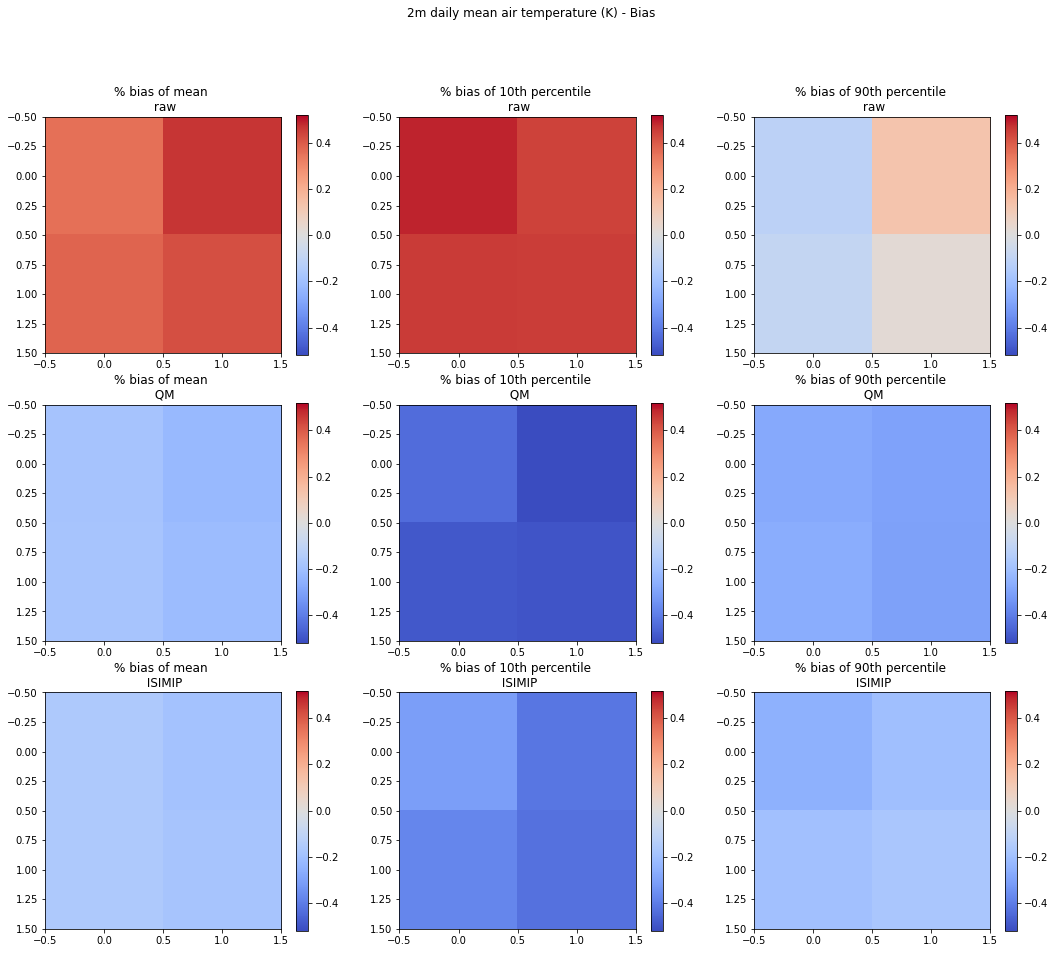

In [15]:
tas_bias_map = marginal.plot_bias_spatial(variable = 'tas', data_obs = tas_obs_validate, data_raw = tas_cm_future,
                        QM = tas_debiased_QM, ISIMIP = tas_debiased_ISIMIP)
tas_bias_map.show()

## 4. 2. Exceedance over threshold analysis

This section focuses on exceedance over threshold analysis as this is often particularly relevant for specific impacts the user meight be interested in (frost days, days above 30°C etc). The current implementation looks at hot/cold (respectively wet/dry etc days for other variables). The user can set the threshold below or above which they would like to investigate. 

The analysis is inspired by Maraun et al 2021 (https://doi.org/10.1029/2020JD032824), the ESMValTool (https://www.esmvaltool.org/) and these climate change indices http://etccdi.pacificclimate.org/list_27_indices.shtml.

The section will be expanded to incorporate the full set of climate change indices (link above) that the user can then choose from, as well as a full GEV analysis for users that are interested in the statistical properties of their bias corrected output.


In [11]:
# define thresholds

threshold_dictionary = {
    "frost": {
        "variable": 'tasmin',
        "variablename": '2m daily minimum air temperature (K)',
        "value": 273.15,
        "threshold_sign": 'lower',
        "name": 'Frost days'
    },
    "mean_warm_day": {
        "variable": 'tas',
        "variablename": '2m daily mean air temperature (K)',
        "value": 295,
        "threshold_sign": 'higher',
        "name": 'Warm days (mean)'
    },
    "mean_cold_day": {
        "variable": 'tas',
        "variablename": '2m daily mean air temperature (K)',
        "value": 273,
        "threshold_sign": 'lower',
        "name": 'Cold days (mean)'
    }
}

### 4. 2. 1. Marginal

Output of this section is the distribution of marginal bias in hot and cold days over the entire area. This is shown for one in a violinplot (for summary purpose), and a spatial plot. As also stated in the previous section, the spatial plot helps identify areas with particularly high biases that point to large-scale biases of the underlying climate model. 

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_50506/2254263906.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_EOT_meanbiasdays_plot.show()


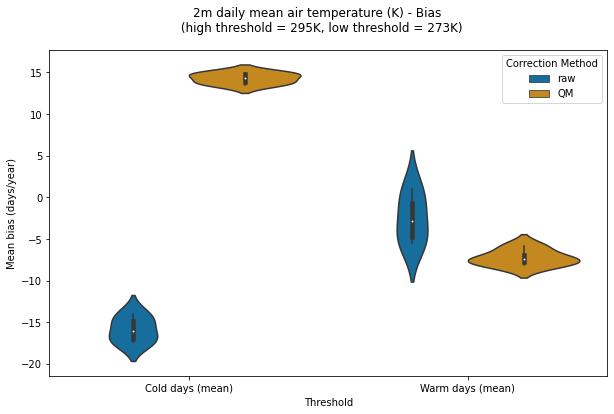

In [8]:
tas_EOT_marginal_bias = EOT.calculate_marginal_bias(thresholds = ['mean_cold_day', 'mean_warm_day'],
                                                        data_obs = tas_obs_validate,
                                                        raw = tas_cm_future,
                                                        QM = tas_debiased_QM)

tas_EOT_meanbiasdays_plot = EOT.plot_distribution_mean_bias_days('tas', tas_EOT_marginal_bias)
tas_EOT_meanbiasdays_plot.show()

**Spatial distribution of mean bias days**

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_50506/2459143937.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_EOT_meanbiasdays_2dplot.show()


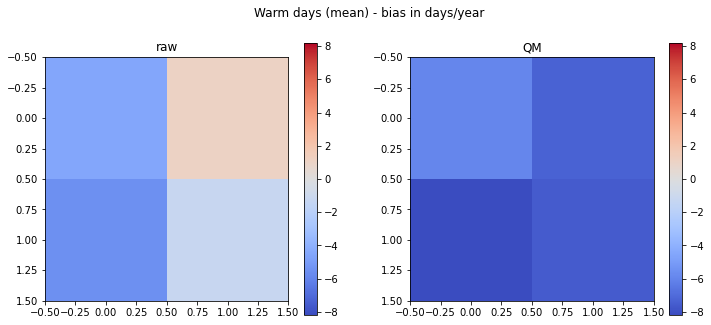

In [9]:
tas_EOT_meanbiasdays_2dplot = EOT.plot_2d_distribution_mean_bias_days(thresholdname = 'mean_warm_day',
                                                        data_obs = tas_obs_validate,
                                                        raw = tas_cm_future,
                                                        QM = tas_debiased_QM)
tas_EOT_meanbiasdays_2dplot.show()

### 4. 2. 2. Spell-length (marginal)

For many impacts, the duration of the extreme condition is important (e.g. heatwaves). Marginal bias correction methods are known to do a bad job at correcting the bias in temporal distribution. This subsection is meant to provide a user with information as to which bias correction method does the best job at reproducing the observed spell length they are most interested in.

Example here: length of hot / cold periods of at least five days

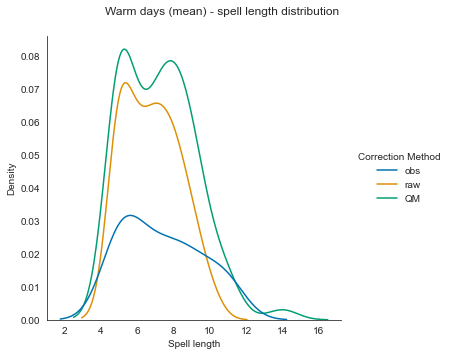

In [10]:
warm_spell_length = EOT.compute_spell_length(thresholdname = 'mean_warm_day', min_length = 4, obs = tas_obs_validate,
                           raw = tas_cm_future, QM = tas_debiased_QM)

warm_spell_length_plot = EOT.plot_clusters_distribution(thresholdname = 'mean_warm_day', plot_data = warm_spell_length,
                                                    clustertype = 'spell length')

### 4. 2. 3. Spatial co-occurrence and spatio-temporal co-occurrence ("spell extent")

Spatial co-occurrence is calculated by computing percent of gridcells above / below the threshold at a given day, given that one cell is above/below the threshold.

Spatio-temporal co-occurrence, in this exceedance over threshold analysis, is defined as the size of connected clusters of thresholds exceedances in space and time dimensions.

All three co-occurrence analyses (temporal, spatial, and spatio-temporal) are connected and are also related to the correlation analysis conducted later. Perhaps analysing the temporal components (spell-length) could be the default mode - and then analysing spatial and spatio-temporal co-occurence could be additional add-ons.

Regarding the density plots: we have been trying different types of plots here (histograms, violin plots) - or not going with plots at all and just using statistical tests - but haven't quite found the way to go yet. 

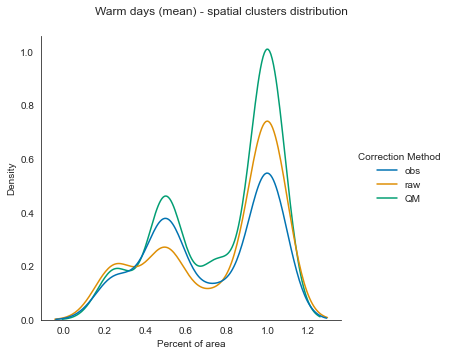

In [11]:
# spatial clusters
warm_spatial_clusters = EOT.calculate_spatial_clusters(thresholdname = 'mean_warm_day', obs = tas_obs_validate,
                                                     raw = tas_cm_future, QM=tas_debiased_QM)
warm_spatial_clusters_plot = EOT.plot_clusters_distribution(thresholdname = 'mean_warm_day', plot_data = warm_spatial_clusters,
                                                    clustertype = 'spatial clusters')

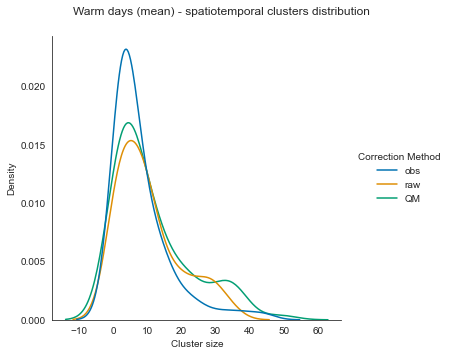

In [14]:
# spatiotemporally connected clusters
warm_spatiotemporal_clusters = EOT.calculate_spatiotemporal_clusters(thresholdname = 'mean_warm_day', obs = tas_obs_validate,
                                                     raw = tas_cm_future, QM=tas_debiased_QM)

warm_spatiotemporal_clusters_plot = EOT.plot_clusters_distribution(thresholdname = 'mean_warm_day', plot_data = warm_spatiotemporal_clusters,
                                                    clustertype = 'spatiotemporal clusters')

## 4. 3. Trend preservation

Quantile Mapping does not automatically preserve the trend in the climate model - in fact, Switanek et al (2017) show that the trend can be distorted by quantile mapping by the order of magnitude of the trend itself. ISIMIP on the other hand is a trend preserving bias correction methodology. 

Whether or not to modify the trend modelled by the climate model is a choice the user has to make - to evaluate whether the trend of the climate model is plausible requires more in-depth diagnostics of the climate model, for example of the kind available through ESMValTools. 

What we can do within this package is simply to show whether the bias correction that the user has applied has modified the climate change trend present in the model - and refer the user to other tools for further analysis.

The way this is currently implemented is WIB, in principle based on Switanek et al 2017. The observed trend between training (1979-2000) and validation period (2000-2014) is compared between observed data, and raw and bias adjusted climate model data.

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_50506/3570223929.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_additive_trend.show()


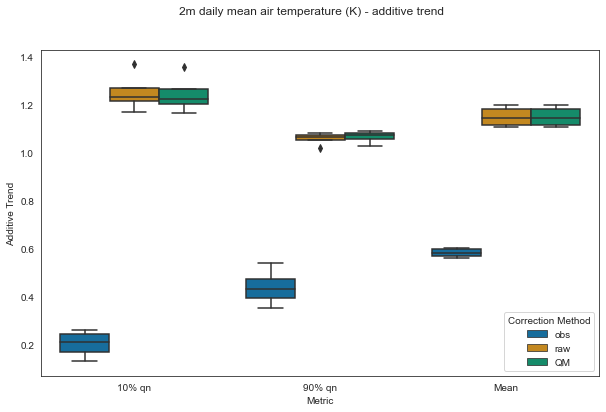

In [52]:
tas_additive_trend = trend_analysis.calculate_trend_bias(variable = 'tas', obs = [tas_obs, tas_obs_validate], 
                                          raw = [tas_cm_hist, tas_cm_future],
                                          QM = [test_debiased_hist, tas_debiased_QM])

tas_additive_trend.show()


## 4. 4. Spatial and multivariate correlation


Work in Progress: Have looked at the autocorrelation function (for temporal auto-correlation), the spatial RMSE of correlation matrices observed vs raw and observed vs bias corrected, as well as multivariate correlation structure. Are not yet really happy with any of the metrics and will continue to work on this section.

### Spatial correlation - Moran's I

Currently not working because of NumPy version conflict

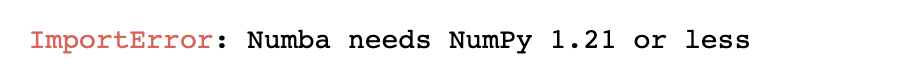

### Spatial correlation - distribution of RMSE between two correlation matrices

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_50506/2806019879.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_rmsd_spatial_plot.show()


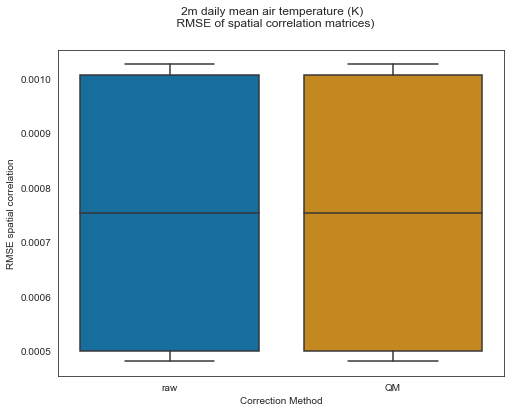

In [80]:
tas_rmsd_spatial = correlation_analysis.rmse_spatial_correlation_distribution(variable = 'tas', 
                                                         data_obs = tas_obs_validate, 
                                                         raw = tas_cm_future,
                                                         QM = tas_debiased_QM)
tas_rmsd_spatial_plot = correlation_analysis.rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmsd_spatial)
tas_rmsd_spatial_plot.show()

### Temporal structure - Autocorrelation function

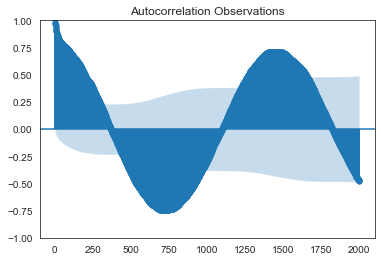

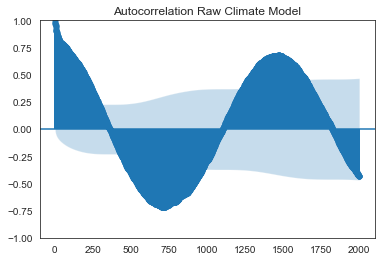

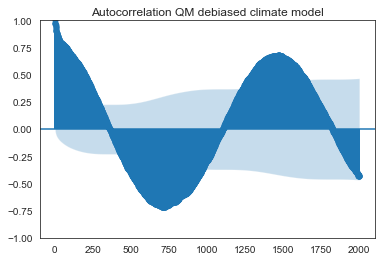

In [89]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(np.ndarray.flatten(tas_obs_validate), lags=2000)
plt.title('Autocorrelation Observations')
plt.show()

# TODO - think about whether np.ndarray.flatten makes sense here

plot_acf(np.ndarray.flatten(tas_cm_future), lags=2000)
plt.title('Autocorrelation Raw Climate Model')
plt.show()

plot_acf(np.ndarray.flatten(tas_debiased_QM), lags=2000)
plt.title('Autocorrelation QM debiased climate model')
plt.show()

# Idea: look at minima and maxima and their timing?

### Multivariate structure - difference in correlation matrices

In [ ]:
# obs = [tas_obs_validate, pr_obs_validate], raw = [tas_cm_future, pr_cm_future], QM = [tas_debiased_QM, pr_debiased_QM]

def multivariate_correlation(variables, **kwargs):
    
    correlation_matrix = {}
    
    for k in kwargs.keys():
        
        variable1 = kwargs[k][0]
        variable2 = kwargs[k][1]
        
        correlation_matrix[k] = np.zeros((variable1.shape[1], variable1.shape[2]))
    
        for i in range(variable1.shape[1]):
                for j in range(variable.shape[2]):
                            
                        correlation_matrix[k][i,j] = np.corrcoef(variable1[:,a,b], variable2[:,i,j])[0,1]

    axis_max = max(abs(max(np.ndarray.flatten(np.vstack(list(chain(*correlation_matrix.values())))))), 
                   abs(min(np.ndarray.flatten(np.vstack(list(chain(*correlation_matrix.values())))))))
    axis_min = -axis_max
    
    fig_width = 6*len(kwargs.keys())
    fig, ax = plt.subplots(1, len(kwargs.keys()), figsize=(fig_width, 5))
    fig.suptitle("Multivariate Correlation: {} and {}".format(variable_dictionary.get(variables[0]).get('name'),
                                                              variable_dictionary.get(variables[1]).get('name')))
    
    i=0
    for k in kwargs.keys():
        
        plot = ax[i].imshow(bias[k], cmap=plt.get_cmap('coolwarm'), vmin = axis_min, vmax = axis_max)
        ax[i].set_title('{}'.format(k))
        fig.colorbar(plot, ax=ax[i])
        i = i+1
        
    return(fig)

## 4. 5. Other impact metrics

# Conclusion

Overall, the Quantile Mapping method implemented in this example performs quite badly:
- there is a clear bimodality (and associated seasonality) in the data that the fit does not account for
- the bias correction 'overcorrects' the bias in both mean as well as high and low quantiles
- the bias adjusted CM performs as bad or worse as the raw CM in representing the probability of hot and cold days
- the length of both hot and cold spells is overestimated by the bias corrected model